# Comparison of numerical model with core measurements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import pyvista as pv
from myusefultools.parser import getVTKList

## Pyvista global settings
pv.set_plot_theme("document")
pv.set_jupyter_backend('static')
pv.global_theme.transparent_background = False
pv.global_theme.show_scalar_bar = True
pv.start_xvfb()

### Load experimental results from cores

In [2]:
## Import experimental results from Fox et al. 2018
with open('./miscellaneous/ExperimentalData.pkl','rb') as f:
    ExperimentalData = pickle.load(f)

## Measurements from cores
experiment = ExperimentalData['Neutral']
ycores = ExperimentalData['Y']
ccores = ExperimentalData['Neutral']['C']
scores = ExperimentalData['Neutral']['std']

### Select the model to draw the comparison

In [3]:
# Select between 'LES' and 'RAS'
dataset_paths = dict(
    LES = r'./subsurface_results_folder/refactored_dp9.LES/VTK/',
    RAS = r'./subsurface_results_folder/refactored_dp9.RANS/VTK/'
)

file_names = { k: getVTKList(v)[-1] for k,v in dataset_paths.items() }
file_paths = { k: os.path.join(dataset_paths[k], file_names[k]) for k in dataset_paths}

### Read VTK fields

In [4]:
datatests = { k: pv.read(v) for k,v in file_paths.items() }

## Get a 2D slice and work on that 
clipPoint  = (0, -0.05, 0)          ## Clip to not show the deeper section
slicePoint = (0, 0, SLICEZ:=0.15)   ## Ignore the 3D and just plot a 2D slice

slices = {k: v.clip(normal='y', origin=clipPoint, invert=False).slice(normal='z', origin=slicePoint) for k,v in datatests.items()}

In [5]:
## Function for plotting with pyvista

def plotField(mesh, field:str): 
    kw_add_mesh = dict(scalars=field,n_colors=128,cmap="Greens",lighting=False)
    plotter = pv.Plotter(off_screen=False)
    plotter.parallel_projection = True
    plotter.add_mesh(mesh,**kw_add_mesh)
    plotter.add_axes()
    plotter.camera_position = 'xy'
    plotter.camera.zoom(2.0)
    plotter.show(window_size=[600,350],return_img=True)

Dataset: LES


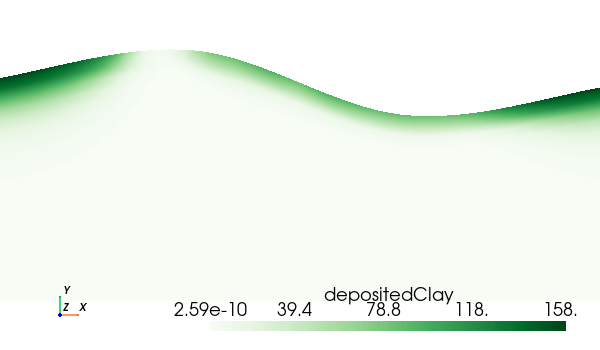

Dataset: RAS


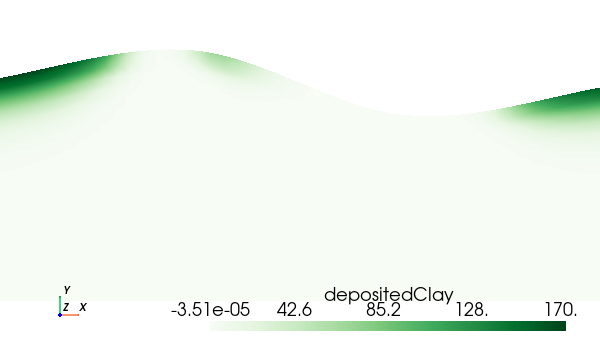

In [6]:
FIELD = "depositedClay"
for k,slice in slices.items():
    print(f"Dataset: {k}")
    plotField(slice, FIELD)

### Convert to mass percentages

Dataset: LES
totalClay


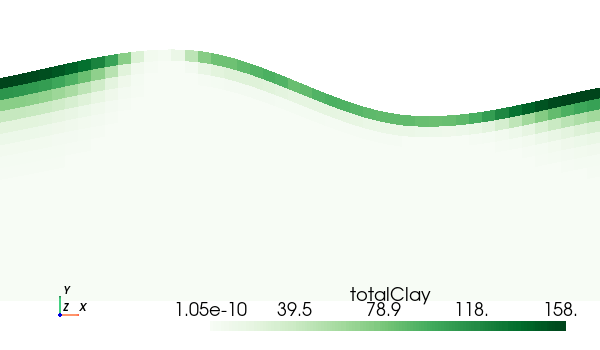

percentClay


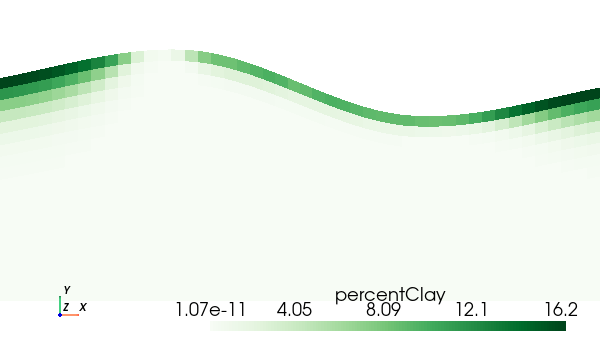

Dataset: RAS
totalClay


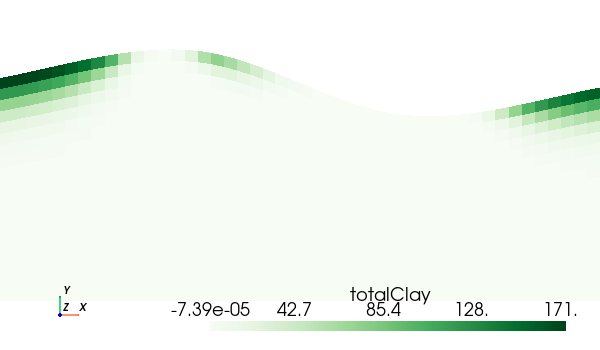

percentClay


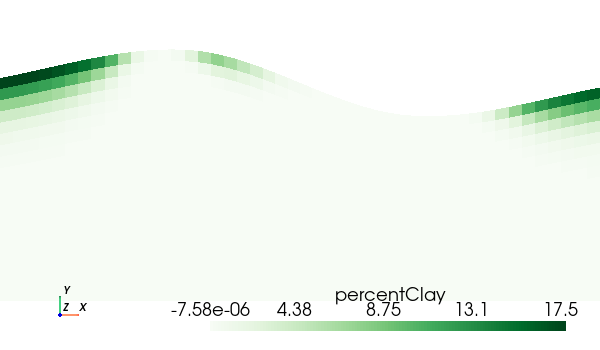

In [7]:
## Convert to percent clay to keep units from Fox et al. 
DENSITY_OF_SAND = 1500.
CLEAN_POROSITY  = 0.350

for k, slice in slices.items():
    print(f"Dataset: {k}")

    slice['totalClay'] = slice['depositedClay'] + (slice['suspendedClay']*slice['n'])
    slice['percentClay'] = 100. * slice['totalClay']/(DENSITY_OF_SAND * (1.0 - CLEAN_POROSITY)) 

    for field in ["totalClay", "percentClay"]: 
        print(field)
        plotField(slice,field)

In [8]:
# Create planes at the core locations
z = SLICEZ - 0.01
cores_planes = [[pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.10,0.13]],
                [pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.14,0.17]],
                [pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.18,0.21]],
                [pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.22,0.25]]]

In [9]:
## Plot lines of cores
cores_id = ['Core A','Core B','Core C','Core D']
core_color = ['r','g','b','darkorange']

## Create a bunch of lines at each core location to probe
probes_resolutionx = 8
cores_x = [np.linspace(0.10,0.13,probes_resolutionx),
           np.concatenate(
            (np.linspace(0.14,0.15,int(probes_resolutionx/2)),
             np.linspace(0.01,0.02,int(probes_resolutionx/2)))),
           np.linspace(0.03,0.06,probes_resolutionx),
           np.linspace(0.07,0.10,probes_resolutionx)]

# Fig Suppl. 1

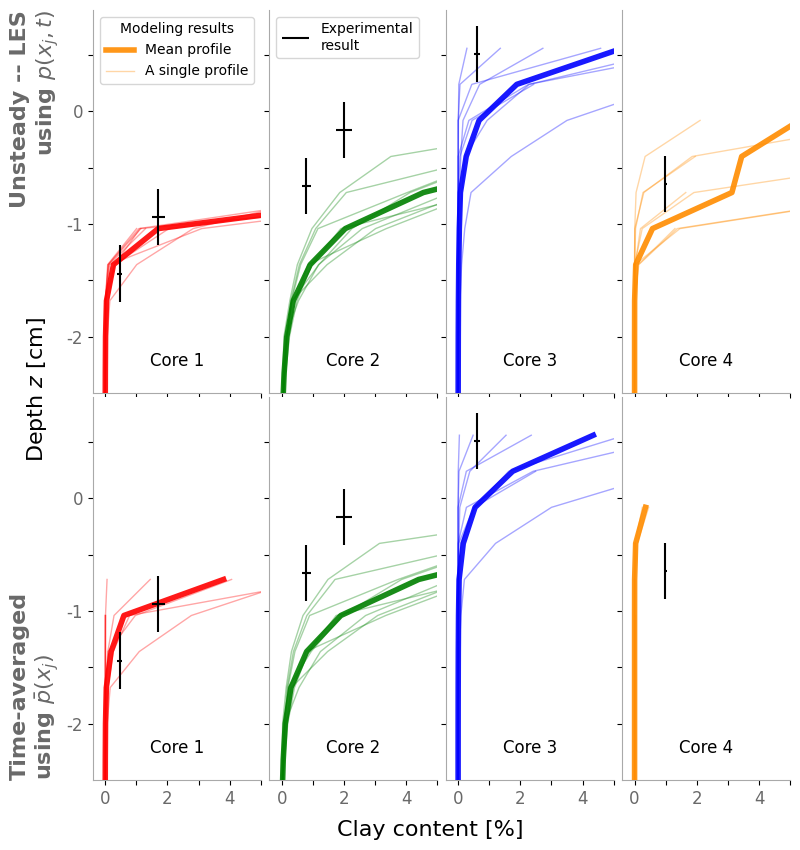

In [10]:
fig,axss = plt.subplots(2,4,sharey=True,sharex=True,
            gridspec_kw={'wspace':0.05, 'hspace':0.01}, figsize=[9,10])


for (k, slice), axs in zip(slices.items(), axss):
    
    ## For each line of each core, run a sample_over_line()
    
    for i,core in enumerate(cores_x):
        pC_accum,y_accum = [],[]
        
        for x in core:
            line_bottom, line_top = (x,-0.10,SLICEZ), (x, 0.06,SLICEZ)
            samples = slice.sample_over_line(line_top, line_bottom, resolution=50)
            pC = np.ma.masked_where(samples['vtkValidPointMask']<1.0, samples['percentClay'])
            y  = np.ma.masked_where(samples['vtkValidPointMask']<1.0, samples.points[:,1])
            pC_accum.append(pC)
            y_accum.append(y)
            
            ## Add line to plot
            littleLine = axs[i].plot(pC, y, color=core_color[i],alpha=0.35, lw=1, zorder=1)

        # Get representative value for core    
        pC_accum = np.ma.stack(pC_accum,axis=0)
        meanPc = pC_accum.mean(axis=0)
        
        y_accum = np.ma.stack(y_accum,axis=0)
        meanY = y_accum.mean(axis=0)
        
        bigLine = axs[i].plot(meanPc,meanY,color=core_color[i],alpha=0.9,lw=4,ls='-',zorder=3)
    
    #stdPc = pC_accum.std(axis=0)
    #axs[i].plot(meanPc+stdPc,meanY,color=core_color[i],alpha=0.9,lw=2,ls='-')
    #axs[i].plot(meanPc-stdPc,meanY,color=core_color[i],alpha=0.9,lw=2,ls='-')

    for y,cv,sv,ax in zip(ycores,ccores,scores,axs):
        dy = 0.5E-2
        y1 = y
        y2 = y - dy
        for c,s in zip(cv,sv):
            linecollection = ax.vlines(c,y2,y1,colors='k',zorder=4)
            ym = (y1+y2)/2
            ax.hlines(ym,c-s,c+s,colors='k',zorder=4)
            y1 -= dy
            y2 -= dy

    ## Miscellaneous 

    for i, ax in enumerate(axs): 
        ax.set_title(f"Core {i+1}", y=0.05)
        ax.spines[['top', 'right']].set_visible(False)
        ax.spines[['left', 'bottom']].set_color('darkgray')
        
    axs[0].set_yticks([0.005,0,-0.005,-0.01,-0.015,-0.02])
    axs[0].set_yticklabels(['','0','','-1','','-2'], color='dimgray', fontsize=12)

xticks = np.arange(0,10,1)
for ax in axss[1,:]:
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(i) if i%2 == 0 else '' for i in xticks],
                       color='dimgray', fontsize=12)

fig.supxlabel('Clay content [%]', fontsize=16, y=0.05)
fig.supylabel('Depth $z$ [cm]', fontsize=16, x=0.05)

axss[0,1].legend([linecollection], ['Experimental\nresult'], 
                   loc='upper left', bbox_to_anchor=(0.0, 1.0))

axss[0,0].legend(bigLine + littleLine, ['Mean profile', 'A single profile'],
                 title="Modeling results")

## LES/RAS annotations

axss[1,0].set_ylabel("Time-averaged\n" r"using $\bar{p}(x_j)$", 
                     labelpad=4, rotation=90, loc='bottom', fontsize=16, fontweight=800, color='dimgray')

axss[0,0].set_ylabel("Unsteady -- LES\n" r"using $p(x_j, t)$", 
                     labelpad=4, rotation=90, loc='top', fontsize=16, fontweight=800, color='dimgray')

axs[0].set_ylim([-0.025, 0.009])
axs[0].set_xlim([-0.4, 5.0])

# plt.savefig("ProfilingCombined.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()